# Setup

In [98]:
from IPython.display import display
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

from causallift import CausalLift
seed = 5
%matplotlib inline

plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [99]:
df = pd.read_csv('../data/BPD_CRIME_DATA_WITHDEMOGRAPHICS.csv')
df.columns

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Index(['Unnamed: 0', 'Unnamed: 0.1', 'Description', 'Inside/Outside', 'Weapon',
       'Post', 'District', 'Neighborhood', 'Longitude', 'Latitude', 'Premise',
       'Season', 'Month', 'Hour', 'Year', 'CSA', 'median_household_income',
       'households_below_poverty', 'perc18_24', 'perc25_64', 'perc65up',
       'perc_asian', 'perc_aa', 'perc_hisp', 'pwhi', 'num_households',
       'median_price_homes_sold'],
      dtype='object')

# Cleaning

In [100]:
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

In [101]:
df.head(10)



,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Premise,Season,...,households_below_poverty,perc18_24,perc25_64,perc65up,perc_asian,perc_aa,perc_hisp,pwhi,num_households,median_price_homes_sold
0,ROBBERY - RESIDENCE,Inside,KNIFE,913.0,SOUTHERN,Brooklyn,-76.60541,39.22951,ROW/TOWNHO,summer,...,24.213606,8.248062,57.449612,7.302326,2.527132,37.961240,14.906977,39.682171,NaN,52000.0
1,AUTO THEFT,Outside,NONE,133.0,CENTRAL,Reservoir Hill,-76.63217,39.31360,STREET,summer,...,25.964546,8.231621,56.940108,11.003879,0.624468,83.990917,2.876336,10.966033,NaN,127500.0
2,SHOOTING,Outside,FIREARM,524.0,NORTHERN,Winston-Govans,-76.60697,39.34768,STREET,summer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AGG. ASSAULT,Inside,OTHER,934.0,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,ROW/TOWNHO,summer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COMMON ASSAULT,Outside,HANDS,113.0,CENTRAL,Downtown West,-76.61365,39.28756,STREET,summer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,BURGLARY,Inside,NONE,922.0,SOUTHERN,Cherry Hill,-76.62131,39.24867,ROW/TOWNHO,summer,...,39.337017,9.134854,45.575112,9.779375,0.929598,87.469013,5.813089,4.362915,NaN,45000.0
6,HOMICIDE,Outside,FIREARM,232.0,SOUTHEASTERN,Canton,-76.56827,39.28202,STREET,summer,...,3.661784,5.849147,75.246217,10.533269,4.383858,3.939467,3.086716,85.575306,NaN,306500.0
7,ROBBERY - STREET,Outside,NONE,123.0,CENTRAL,Upton,-76.62789,39.30254,STREET,summer,...,42.982456,11.429971,47.277179,10.803134,1.860921,91.635651,0.636631,4.221352,NaN,100000.0
8,AGG. ASSAULT,Outside,OTHER,641.0,NORTHWESTERN,Windsor Hills,-76.68365,39.31370,STREET,summer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,COMMON ASSAULT,Inside,HANDS,332.0,EASTERN,Berea,-76.57419,39.30551,ROW/TOWNHO,summer,...,27.649528,8.788912,52.139479,15.157848,0.417996,93.664063,2.034980,2.364976,NaN,42786.0


In [102]:
df['households_below_poverty'].dropna(inplace=True)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [103]:
# Create binary treatment variables
df['Inside/Outside'].value_counts()
df['Inside'] = np.where(df['Inside/Outside'] == 'INSIDE', False, True)



In [104]:
df['households_below_poverty'].value_counts()

7.086614     1833
5.454545     1594
26.333747    1369
16.856025    1225
31.822899    1204
             ... 
21.188630      49
17.408907      43
26.858276      42
26.280624      32
21.687667      29
Name: households_below_poverty, Length: 123, dtype: int64

In [105]:
# Encoding
df['Weapon'] = df['Weapon'].astype('category').cat.codes
df['Neighborhood'] = df['Neighborhood'].astype('category').cat.codes
df['Season'] = df['Season'].astype('category').cat.codes

outcome_names = set(df['Description'].values)
outcome_names

{'AGG. ASSAULT',
 'ARSON',
 'ASSAULT BY THREAT',
 'AUTO THEFT',
 'BURGLARY',
 'COMMON ASSAULT',
 'HOMICIDE',
 'LARCENY',
 'LARCENY FROM AUTO',
 'RAPE',
 'ROBBERY - CARJACKING',
 'ROBBERY - COMMERCIAL',
 'ROBBERY - RESIDENCE',
 'ROBBERY - STREET',
 'SHOOTING'}

# Is Below Average Poverty Treatment

In [106]:
cm_df = df.copy()
cm_df['households_below_poverty'] = cm_df['households_below_poverty'].dropna()
cm_df.reset_index(inplace=True)
households_below_avg_poverty = cm_df['households_below_poverty'].mean()
cm_df['Treatment'] = np.where(df['households_below_poverty'] <= households_below_avg_poverty, 1, 0)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re


ASSAULT BY THREAT

[Estimate propensity scores for Inverse Probability Weighting.]
[2021-04-06 16:48:34,633|causallift.context.flexible_context|INFO] Run pipeline (tags: ['011_bundle_train_and_test_data'], SequentialRunner, only_missing: False)
[2021-04-06 16:48:34,641|kedro.pipeline.node|INFO] Running node: bundle_train_and_test_data([args_raw,test_df,train_df]) -> [df_00]
[2021-04-06 16:48:34,659|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2021-04-06 16:48:34,660|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2021-04-06 16:48:34,666|causallift.context.flexible_context|INFO] Run pipeline (tags: ['121_prepare_args', '131_treatment_fractions_', '141_initialize_model'], SequentialRunner, only_missing: False)
[2021-04-06 16:48:34,675|kedro.pipeline.node|INFO] Running node: treatment_fractions_([args_raw,df_00]) -> [treatment_fractions]
[2021-04-06 16:48:34,686|kedro.runner.sequential_runner|INFO] Completed 1 out of 3 tasks
[2021-04-0

,Weapon,Neighborhood,Season
coefficient,0.039977,-0.004087,0.029941


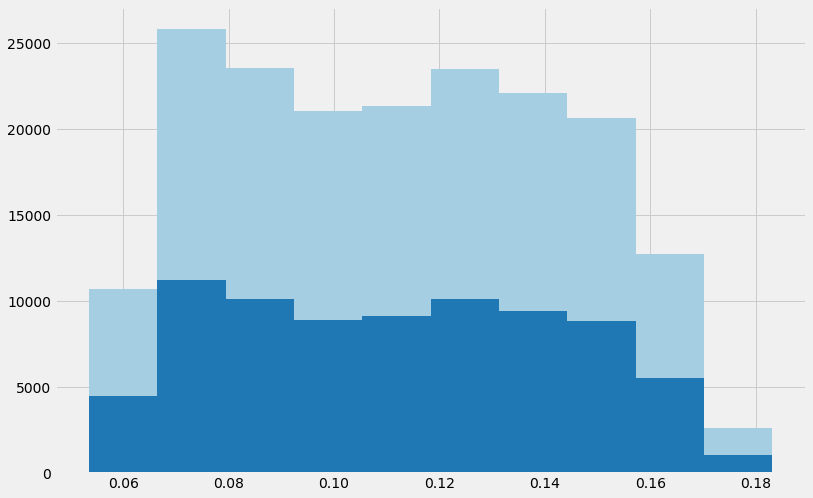

,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,184184,2,0.888020,0.0,0.0,0.0,0.5,0.111980,0.0
test,78937,2,0.888025,0.0,0.0,0.0,0.5,0.111975,0.0


,Pred_0,Pred_1
True_0,163559,0
True_1,20625,0


,Pred_0,Pred_1
True_0,70098,0
True_1,8839,0


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,20625,2,0.988848,0.0,0.0,0.0,0.5,0.011152,0.0
test,8839,2,0.989931,0.0,0.0,0.0,0.5,0.010069,0.0


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,163559,2,0.987534,0.0,0.0,0.0,0.5,0.012466,0.0
test,70098,2,0.986647,0.0,0.0,0.0,0.5,0.013353,0.0


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,20625,2,0.980558,0.0,0.0,0.0,0.5,0.019442,0.0
test,8839,2,0.982917,0.0,0.0,0.0,0.5,0.017083,0.0


,# samples chosen,observed CVR,# samples recommended,predicted CVR,pred/obs CVR
partition,,,,,
train,20625,0.011152,20625,0.0,0.0
test,8839,0.010069,8839,0.0,0.0


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,163559,2,0.988579,0.0,0.0,0.0,0.5,0.011421,0.0
test,70098,2,0.987532,0.0,0.0,0.0,0.5,0.012468,0.0


,# samples chosen,observed CVR,# samples recommended,predicted CVR,pred/obs CVR
partition,,,,,
train,163559,0.012466,163559,0.0,0.0
test,70098,0.013353,70098,0.0,0.0


,# samples,observed CVR,predicted CVR,pred/obs CVR
partition,,,,
train,184184,0.012319,0.0,0.0
test,78937,0.012985,0.0,0.0


,# samples,observed CVR,predicted CVR,pred/obs CVR
partition,,,,
train,184184,0.012319,0.0,0.0
test,78937,0.012985,0.0,0.0


,Weapon,Neighborhood,Season
coefficient,0.039977,-0.004087,0.029941


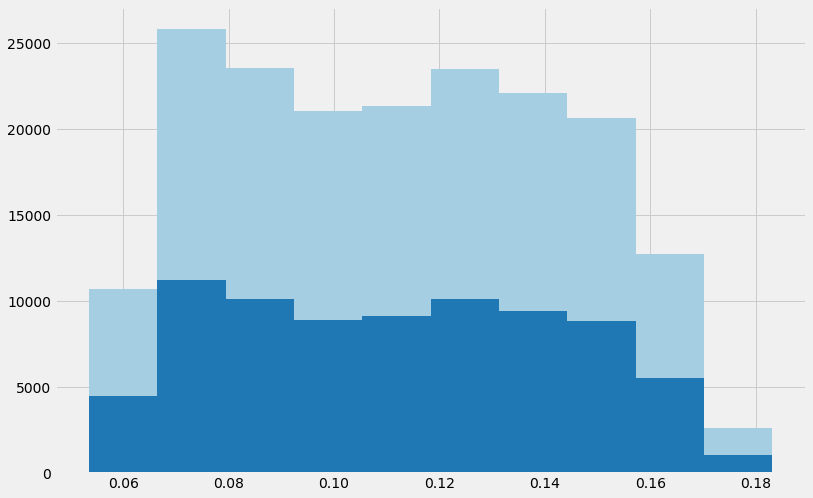

,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,184184,2,0.888020,0.0,0.0,0.0,0.5,0.111980,0.0
test,78937,2,0.888025,0.0,0.0,0.0,0.5,0.111975,0.0


,Pred_0,Pred_1
True_0,163559,0
True_1,20625,0


,Pred_0,Pred_1
True_0,70098,0
True_1,8839,0


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,20625,2,0.896824,0.0,0.0,0.0,0.5,0.103176,0.0
test,8839,2,0.896368,0.0,0.0,0.0,0.5,0.103632,0.0


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,163559,2,0.902255,0.0,0.0,0.0,0.5,0.097745,0.0
test,70098,2,0.906488,0.0,0.0,0.0,0.5,0.093512,0.0


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,20625,2,0.836315,0.0,0.0,0.0,0.5,0.163685,0.0
test,8839,2,0.841611,0.0,0.0,0.0,0.5,0.158389,0.0


,# samples chosen,observed CVR,# samples recommended,predicted CVR,pred/obs CVR
partition,,,,,
train,20625,0.103176,20625,0.0,0.0
test,8839,0.103632,8839,0.0,0.0


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,163559,2,0.909886,0.0,0.0,0.0,0.5,0.090114,0.0
test,70098,2,0.913393,0.0,0.0,0.0,0.5,0.086607,0.0


,# samples chosen,observed CVR,# samples recommended,predicted CVR,pred/obs CVR
partition,,,,,
train,163559,0.097745,163559,0.0,0.0
test,70098,0.093512,70098,0.0,0.0


,# samples,observed CVR,predicted CVR,pred/obs CVR
partition,,,,
train,184184,0.098353,0.0,0.0
test,78937,0.094645,0.0,0.0


,# samples,observed CVR,predicted CVR,pred/obs CVR
partition,,,,
train,184184,0.098353,0.0,0.0
test,78937,0.094645,0.0,0.0


,Weapon,Neighborhood,Season
coefficient,0.039977,-0.004087,0.029941


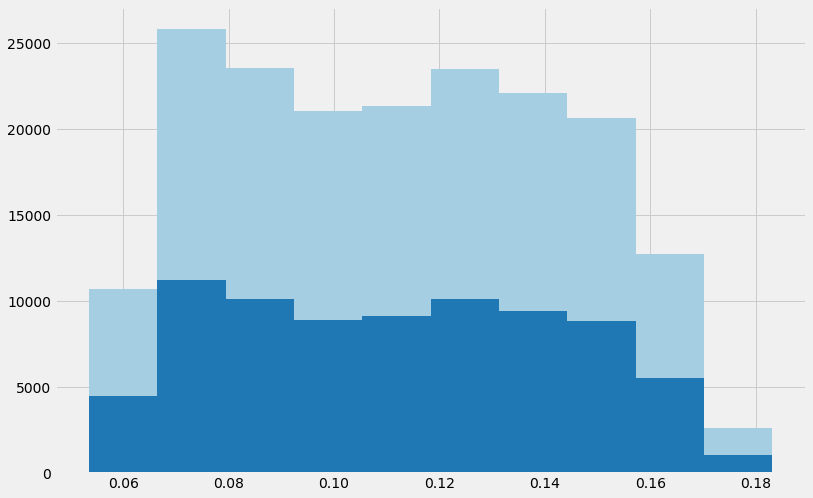

,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,184184,2,0.888020,0.0,0.0,0.0,0.5,0.111980,0.0
test,78937,2,0.888025,0.0,0.0,0.0,0.5,0.111975,0.0


,Pred_0,Pred_1
True_0,163559,0
True_1,20625,0


,Pred_0,Pred_1
True_0,70098,0
True_1,8839,0


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,20625,2,0.994133,0.0,0.0,0.0,0.5,0.005867,0.0
test,8839,2,0.993325,0.0,0.0,0.0,0.5,0.006675,0.0


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,163559,2,0.994974,0.0,0.0,0.0,0.5,0.005026,0.0
test,70098,2,0.994622,0.0,0.0,0.0,0.5,0.005378,0.0


KeyboardInterrupt: 

In [107]:
for outcome in outcome_names:
    print('\n{}'.format(outcome))
    cm_df['Outcome'] = np.where(df['Description'] == outcome, 1, 0)
    cm_df = cm_df[['Treatment', 'Outcome', 'Weapon', 'Neighborhood', 'Season']]

    train_df, test_df = train_test_split(cm_df, test_size=0.3, random_state=seed, stratify=cm_df['Treatment'])

    print('\n[Estimate propensity scores for Inverse Probability Weighting.]')
    cl = CausalLift(train_df, test_df, enable_ipw=True, verbose=3)

    print('\n[Create 2 models for treatment and untreatment and estimate CATE (Conditional Average Treatment Effects)]')
    train_df, test_df = cl.estimate_cate_by_2_models()

    print('\n[Estimate the effect of recommendation based on the uplift model]')
    estimated_effect_df = cl.estimate_recommendation_impact()

    print('\n[Show the estimated effect of recommendation based on the uplift model]')
    display(estimated_effect_df)